In [22]:
# Adding src/ folder to import path
import sys

sys.path.append("../src")

import os.path

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from birdclef.load_data import *
from birdclef.postprocessing import *

DATA_PATH = "/workspace/Data/birdclef-2021"
SAMPLE_RATE = 32000
NORM_ENERGY = 100
N_MEL = 200

# BirdCLEF 2021 - Bird Call Identification

Birds of a feather flock together. Thankfully, this makes it easier to hear them! There are over 10,000 bird species around the world. Identifying the red-winged blackbirds or Bewick’s wrens in an area, for example, can provide important information about the habitat. As birds are high up in the food chain, they are excellent indicators of deteriorating environmental quality and pollution. Monitoring the status and trends of biodiversity in ecosystems is no small task. With proper sound detection and classification—aided by machine learning—researchers can improve their ability to track the status and trends of biodiversity in important ecosystems, enabling them to better support global conservation efforts.

Recent advances in machine listening have improved acoustic data collection. However, it remains a challenge to generate analysis outputs with high precision and recall. The majority of data is unexamined due to a lack of effective tools for efficient and reliable extraction of the signals of interests (e.g., bird calls).

The Cornell Lab of Ornithology is dedicated to advancing the understanding and protection of birds and the natural world. The Lab joins with people from all walks of life to make new scientific discoveries, share insights, and galvanize conservation action. For this competition, they're collaborating with Google Research, LifeCLEF, and Xeno-canto.

In this notebook we automate the acoustic identification of birds in soundscape recordings. We will examine an acoustic dataset to build detectors and classifiers to extract the signals of interest (bird calls).

### Files

__train_short_audio__ - The bulk of the training data consists of short recordings of individual bird calls generously uploaded by users of xenocanto.org. These files have been downsampled to 32 kHz where applicable to match the test set audio and converted to the ogg format. The training data should have nearly all relevant files; we expect there is no benefit to looking for more on xenocanto.org.

__train_soundscapes__ - Audio files that are quite comparable to the test set. They are all roughly ten minutes long and in the ogg format. The test set also has soundscapes from the two recording locations represented here.

__test_soundscapes__ - When you submit a notebook, the test_soundscapes directory will be populated with approximately 80 recordings to be used for scoring. These will be roughly 10 minutes long and in ogg audio format. The file names include the date the recording was taken, which can be especially useful for identifying migratory birds.

This folder also contains text files with the name and approximate coordinates of the recording location plus a csv with the set of dates the test set soundscapes were recorded.

__test.csv__ - Only the first three rows are available for download; the full test.csv is in the hidden test set.

- `row_id`: ID code for the row.
- `site`: Site ID.
- `seconds`: the second ending the time window
- `audio_id`: ID code for the audio file.

In [3]:
pd.read_csv(DATA_PATH + "/test.csv")

,row_id,site,audio_id,seconds
0,3575_COL_5,COL,3575,5
1,3575_COL_10,COL,3575,10
2,3575_COL_15,COL,3575,15


__train_metadata.csv__ - A wide range of metadata is provided for the training data. The most directly relevant fields are:

- `primary_label`: a code for the bird species. You can review detailed information about the bird codes by appending the code to https://ebird.org/species/, such as https://ebird.org/species/amecro for the American Crow.
- `recodist`: the user who provided the recording.
- `latitude` & `longitude`: coordinates for where the recording was taken. Some bird species may have local call 'dialects,' so you may want to seek geographic diversity in your training data.
- `date`: while some bird calls can be made year round, such as an alarm call, some are restricted to a specific season. You may want to seek temporal diversity in your training data.
- `filename`: the name of the associated audio file.

In [4]:
metadata_df = pd.read_csv(DATA_PATH + "/train_metadata.csv")
metadata_df = metadata_df[
    [
        "primary_label",
        "latitude",
        "longitude",
        "date",
        "time",
        "rating",
        "filename",
        "common_name",
        "scientific_name",
    ]
]
metadata_df

,primary_label,latitude,longitude,date,time,rating,filename,common_name,scientific_name
0,acafly,35.3860,-84.1250,2012-08-12,09:30,2.5,XC109605.ogg,Acadian Flycatcher,Empidonax virescens
1,acafly,9.1334,-79.6501,2000-12-26,?,3.0,XC11209.ogg,Acadian Flycatcher,Empidonax virescens
2,acafly,5.7813,-75.7452,2012-01-10,15:20,3.0,XC127032.ogg,Acadian Flycatcher,Empidonax virescens
3,acafly,4.6717,-75.6283,2009-06-19,07:50,3.5,XC129974.ogg,Acadian Flycatcher,Empidonax virescens
4,acafly,4.6717,-75.6283,2009-06-19,07:50,3.5,XC129981.ogg,Acadian Flycatcher,Empidonax virescens
...,...,...,...,...,...,...,...,...,...
62869,yetvir,30.2150,-97.6505,2020-07-10,08:30,1.0,XC591680.ogg,Yellow-throated Vireo,Vireo flavifrons
62870,yetvir,42.3005,-72.5877,2019-05-31,09:30,5.0,XC600085.ogg,Yellow-throated Vireo,Vireo flavifrons
62871,yetvir,42.3005,-72.5877,2020-06-02,08:30,4.5,XC602701.ogg,Yellow-throated Vireo,Vireo flavifrons
62872,yetvir,32.2357,-99.8811,2019-04-27,17:30,4.0,XC614733.ogg,Yellow-throated Vireo,Vireo flavifrons


__train_soundscape_labels.csv__ -

- `row_id`: ID code for the row.
- `site`: Site ID.
- `seconds`: the second ending the time window
- `audio_id`: ID code for the audio file.
- `birds`: space delimited list of any bird songs present in the 5 second window. The label nocall means that no call occurred.

In [5]:
labels_df = pd.read_csv(DATA_PATH + "/train_soundscape_labels.csv")
labels_df

,row_id,site,audio_id,seconds,birds
0,7019_COR_5,COR,7019,5,nocall
1,7019_COR_10,COR,7019,10,nocall
2,7019_COR_15,COR,7019,15,nocall
3,7019_COR_20,COR,7019,20,nocall
4,7019_COR_25,COR,7019,25,nocall
...,...,...,...,...,...
2395,54955_SSW_580,SSW,54955,580,nocall
2396,54955_SSW_585,SSW,54955,585,grycat
2397,54955_SSW_590,SSW,54955,590,grycat
2398,54955_SSW_595,SSW,54955,595,nocall


## Preprocessed Data

See `notes` notebook for details on the pre-processing steps.

In [10]:
metadata_df = pd.read_csv(DATA_PATH + "/outputs/train_metadata.csv")

## Observations

1. Frequency count for top 100 birds in data:

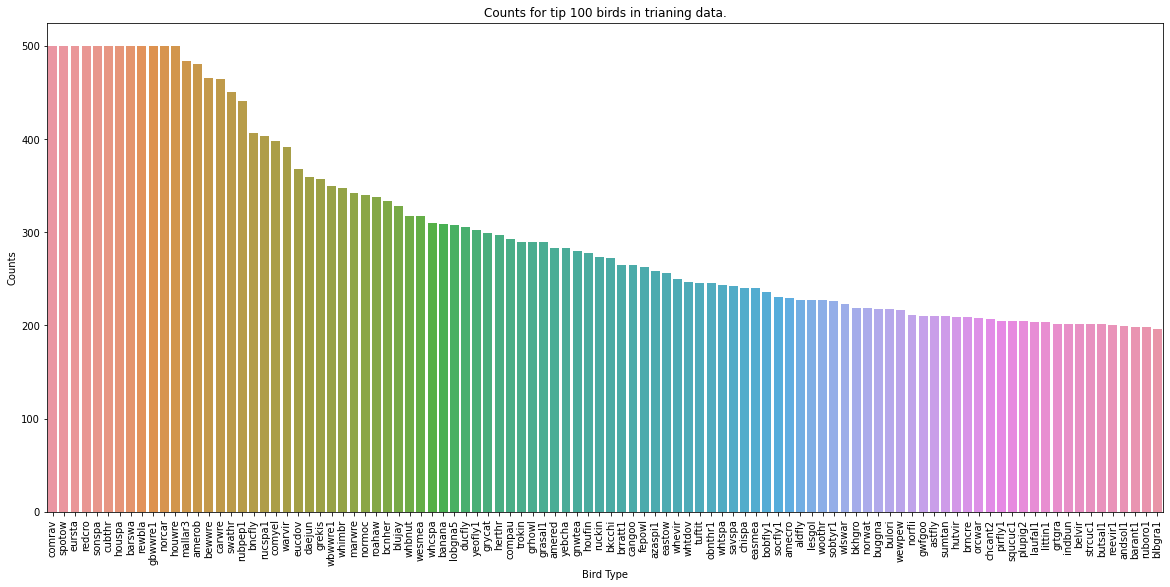

In [16]:
bird_counts = metadata_df["primary_label"].value_counts()[:100]
_, ax = plt.subplots(figsize=(20, 9))
sb.barplot(x=bird_counts.index, y=bird_counts.values, ax=ax)
_ = plt.xticks(rotation=90)
_ = plt.title("Counts for tip 100 birds in trianing data.")
_ = plt.ylabel("Counts")
_ = plt.xlabel("Bird Type")

2. Number of birds observed per year:

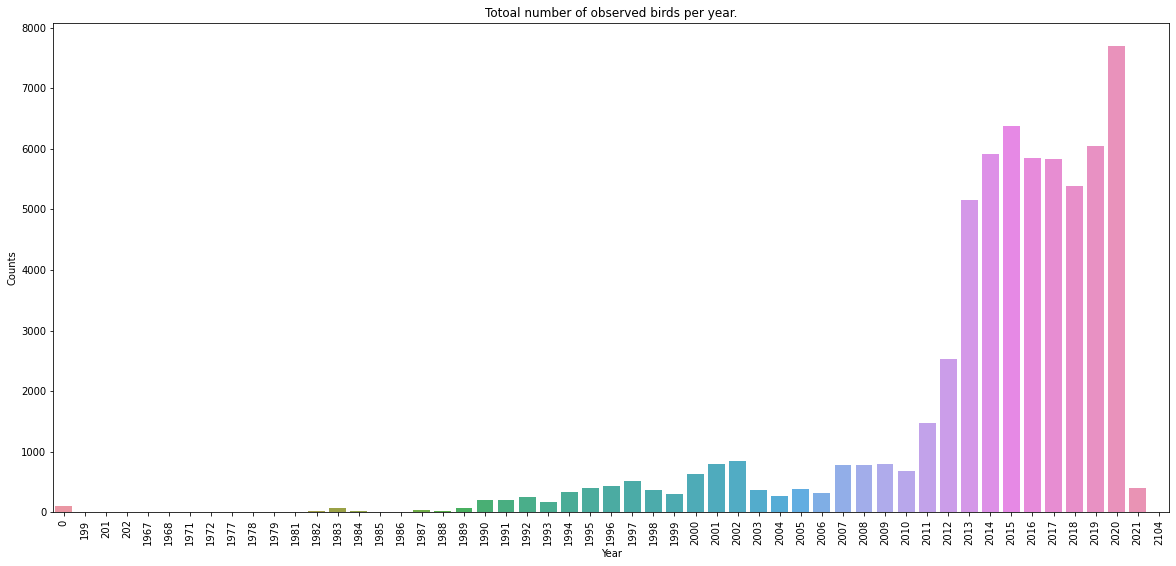

In [17]:
bird_counts = metadata_df["year"].value_counts().sort_index()
_, ax = plt.subplots(figsize=(20, 9))
sb.barplot(x=bird_counts.index, y=bird_counts.values, ax=ax)
_ = plt.xticks(rotation=90)
_ = plt.title("Totoal number of observed birds per year.")
_ = plt.ylabel("Counts")
_ = plt.xlabel("Year")

3. Contingency table between the location where the birds are observed and the type of bird:

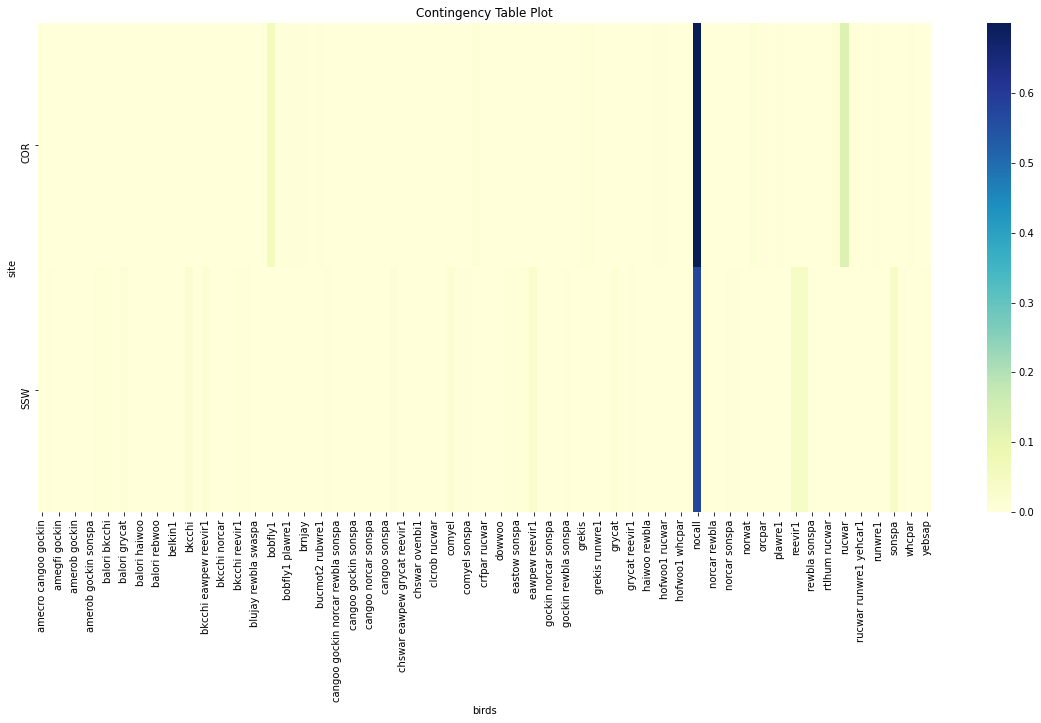

In [35]:
contingency = pd.crosstab(labels_df["site"], labels_df["birds"], normalize="index")
_, ax = plt.subplots(figsize=(20, 9))
sb.heatmap(contingency, fmt=".2f", cmap="YlGnBu", ax=ax)
_ = plt.title("Contingency Table Plot")

4. Contingency table (column normalized) between month of the year when a bird is observed and the type of bird:

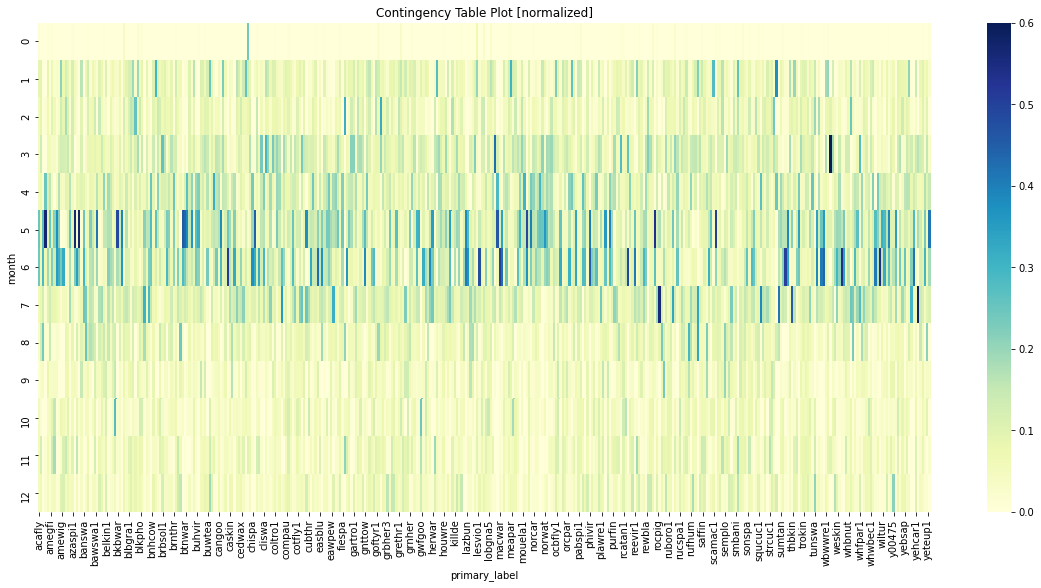

In [34]:
contingency = pd.crosstab(
    metadata_df.month, metadata_df.primary_label, normalize="columns"
)
_, ax = plt.subplots(figsize=(20, 9))
sb.heatmap(contingency, fmt=".2f", cmap="YlGnBu", ax=ax)
_ = plt.title("Contingency Table Plot [normalized]")

5. Distribution of short audio recording durations: 

<AxesSubplot:xlabel='audio_duration', ylabel='Count'>

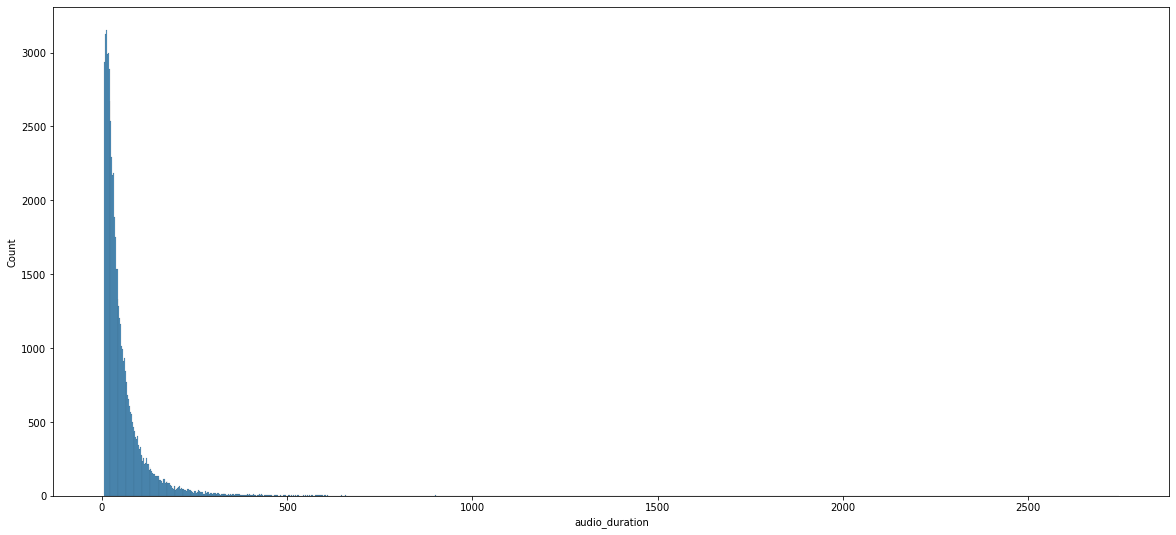

In [36]:
_, ax = plt.subplots(figsize=(20, 9))
sb.histplot(data=metadata_df["audio_duration"], ax=ax)

In [37]:
metadata_df["audio_duration"].describe()

count    62874.000000
mean        56.255305
std         74.042363
min          5.958125
25%         18.378250
50%         34.260688
75%         66.205000
max       2745.352937
Name: audio_duration, dtype: float64

#### Spectogram

The spectorgram of an audio signal is given by the magnitude of its Short-Time Fourier Transform (STFT). The STFT is a Fourier-related transform used to determine the sinusoidal frequency and phase content of a local section of a signal as it changes over time. In other words, STFT gives the amount of different frequencies present in a small section of an audio signal. Let $s(t)$ be the audio signal and $w_{\Delta t}(t)$ be a window function, i.e. a function which is nonzero for only a short period of time $\Delta t$ centered around zero. The STFT is then given by: $$STFT_{\Delta t}(\omega, \tau) = \int_{-\infty}^{\infty} x(t) w_{\Delta t}(t - \tau) e^{-i \omega t} \, dt$$

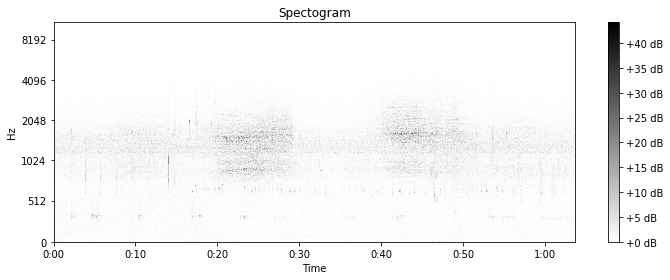

In [26]:
signal = load_short_audio(
    "acafly", "XC109605.ogg", DATA_PATH + "/train_short_audio", SAMPLE_RATE
)
D = librosa.stft(signal)

plt.figure(figsize=(10, 4))
librosa.display.specshow(
    np.abs(D), sr=SAMPLE_RATE, y_axis="mel", fmax=None, x_axis="time", cmap="gray_r"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Spectogram")
plt.tight_layout()